<a href="https://colab.research.google.com/github/debojit11070/deep-learning/blob/main/skin_cancer_classification_with_cnn(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we have 7 different classes of skin cancer.

Melanocytic nevi (nv)

Melanoma (mel)

Benign keratosis-like lesions (bkl)

Basal cell carcinoma

Actinic keratoses

Vascular lesions

Dermatofibroma (df)

**Importing dependencies**

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

**Loading the Data**

In [ ]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [ ]:
df.shape

(10015, 7)

**Data Preprocessing**

Creating dictionary for displaying more human-friendly labels.

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

**Merge images from both folders into one dictionary**

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [ ]:
print(imageid_path_dict)

{'ISIC_0028933': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028933.jpg', 'ISIC_0028394': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028394.jpg', 'ISIC_0027799': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027799.jpg', 'ISIC_0028100': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028100.jpg', 'ISIC_0027960': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027960.jpg', 'ISIC_0028872': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028872.jpg', 'ISIC_0026412': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0026412.jpg', 'ISIC_0024872': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0024872.jpg', 'ISIC_0026232': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0026232.jpg', 'ISIC_0027031': '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027031.jpg', 'ISIC_0026692': '../input/skin-cancer-mnist-ham10

**Creating new columns for better understanding of features**

In [ ]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes


In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Bening keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Bening keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Bening keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Bening keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Bening keratosis-like lesions,2


**Data Cleaning**

In [ ]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [ ]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

**Exploratory Data Analysis**

Gender wise differentiability

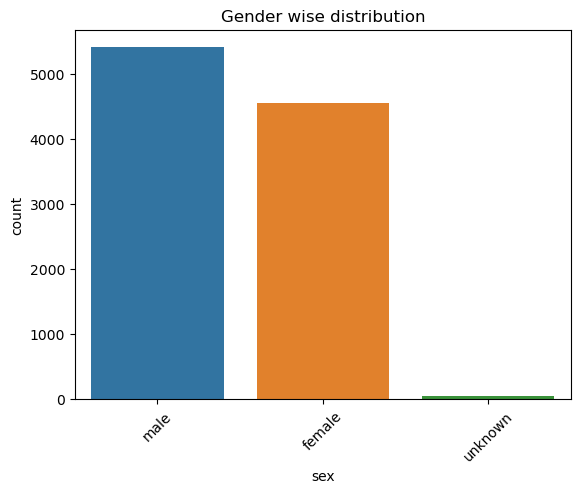

In [ ]:
ax = sns.countplot(x = 'sex', data = df)
plt.title('Gender wise distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

We can see that males are more affected.

Cell type affect on patients

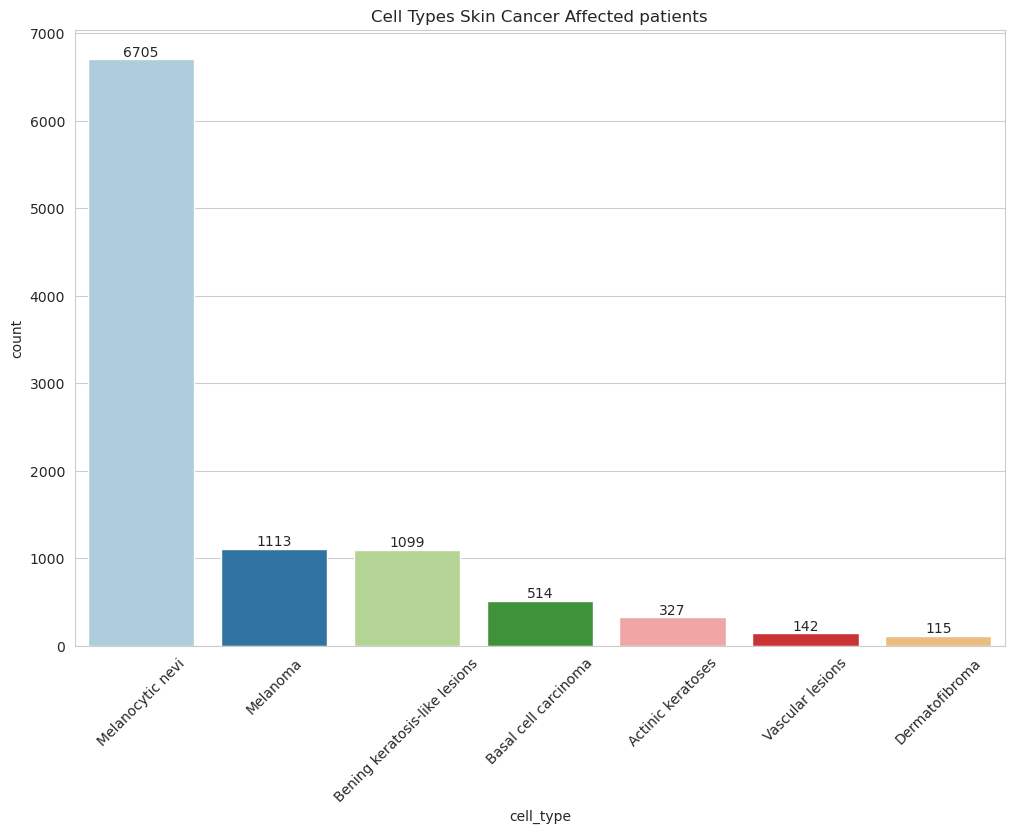

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

1. The number of cases of Melanocytic nevi is way more that others
2. Melonoma which is more critical is less wide spread.

Gender vs Cell Type

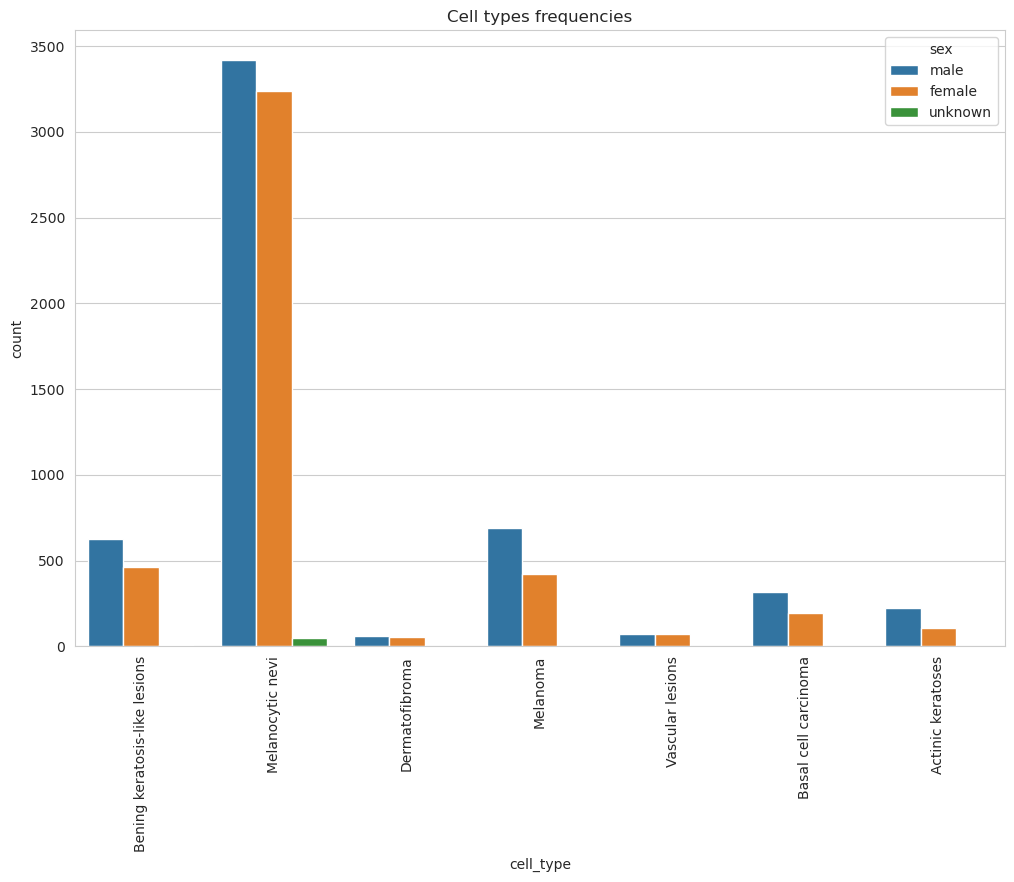

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type', hue='sex', data = df)
plt.title('Cell types frequencies')
plt.xticks(rotation=90)
plt.show()

We can see that for any type of cancer, majority of the victims are males.

Cell Type

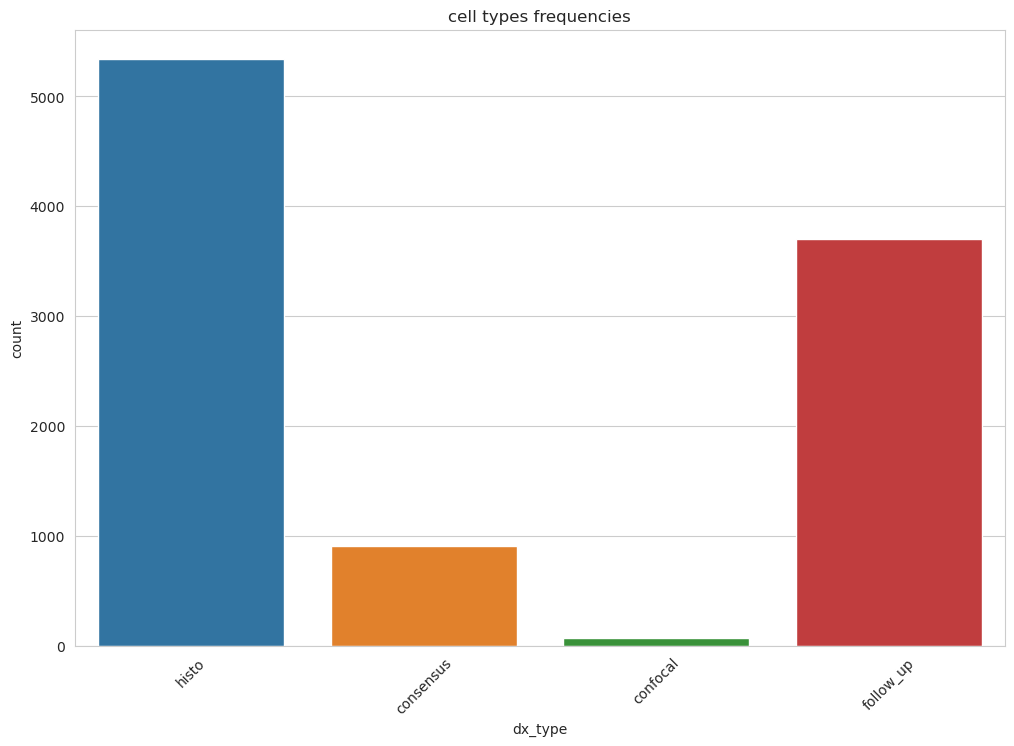

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type', data=df)
plt.title('cell types frequencies')
plt.xticks(rotation=45)
plt.show()

Gender wise cell type distribution

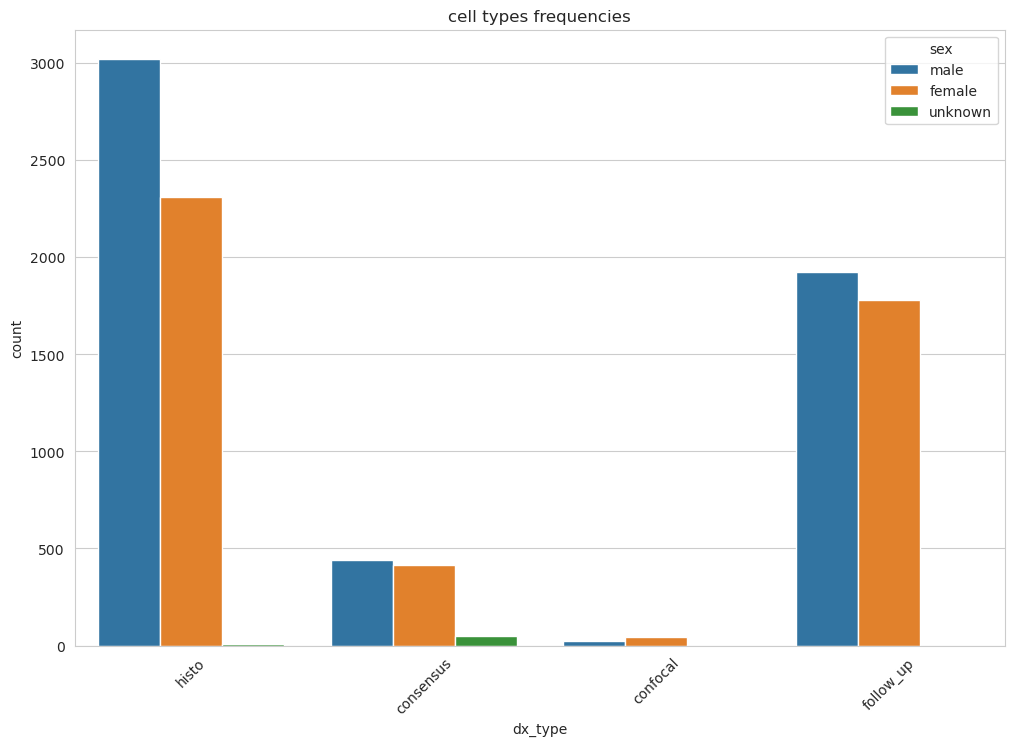

In [ ]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type', hue = 'sex', data = df)
plt.title('cell types frequencies')
plt.xticks(rotation=45)
plt.show()

Localization area

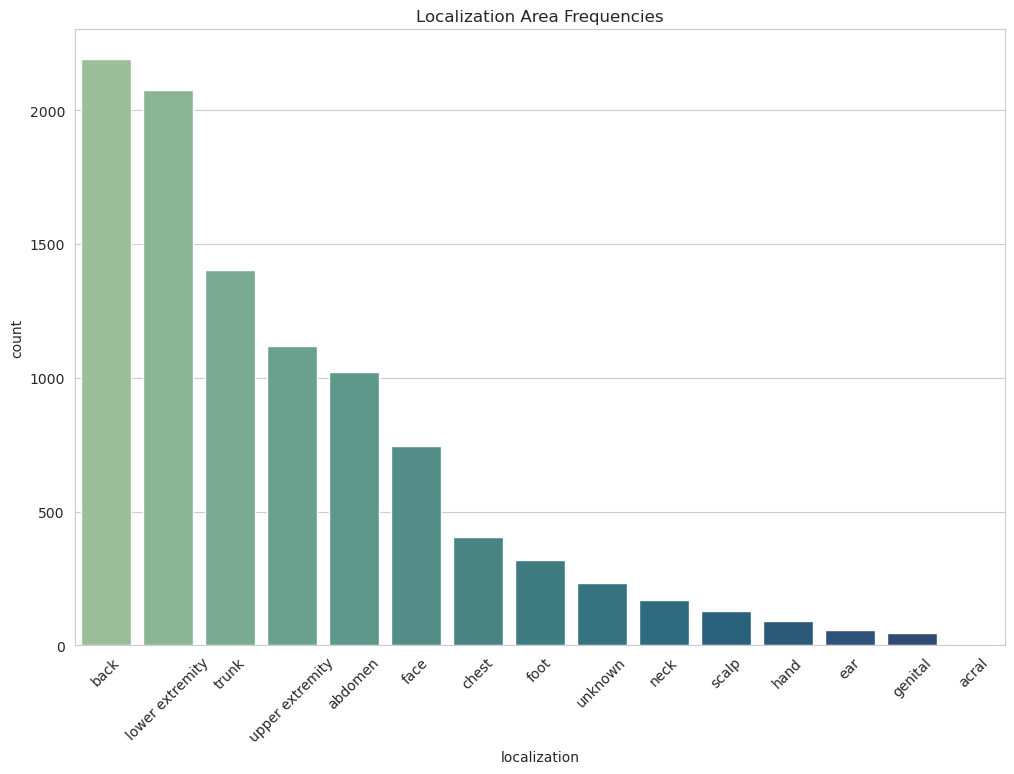

In [ ]:
sns.set_style('whitegrid')
fig,axis = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization', data=df, order=df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

We can see that the most affected areas are back and lower extremity.

Genderwise localization areas


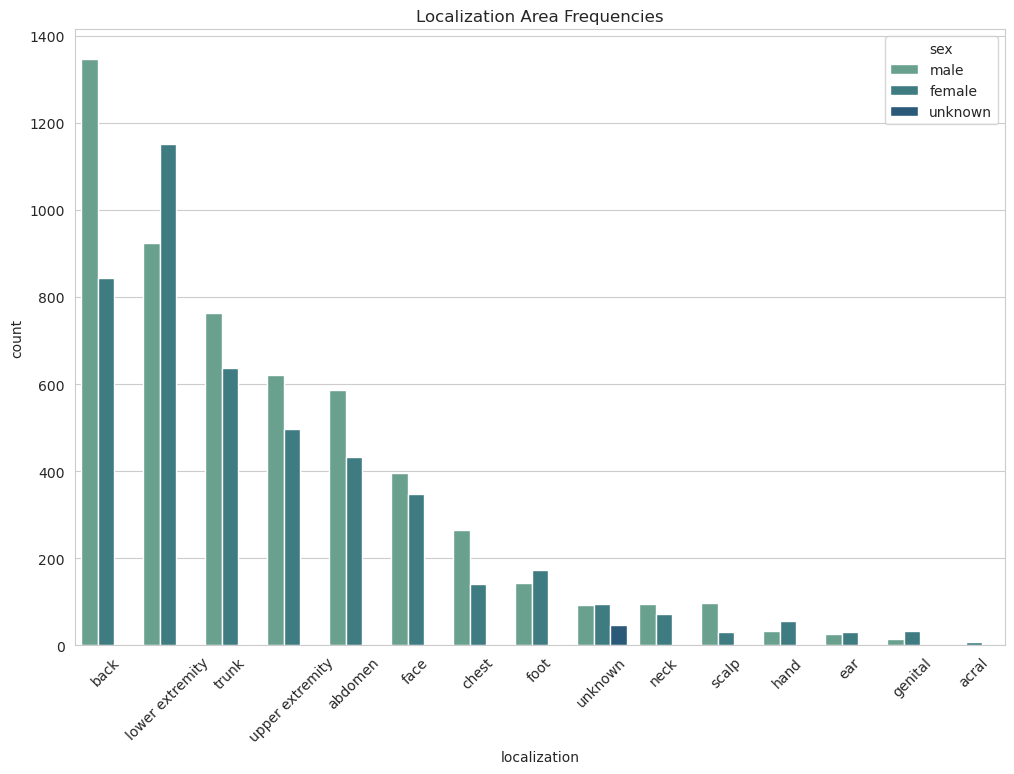

In [ ]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'localization', hue = 'sex', data = df, order = df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

Age

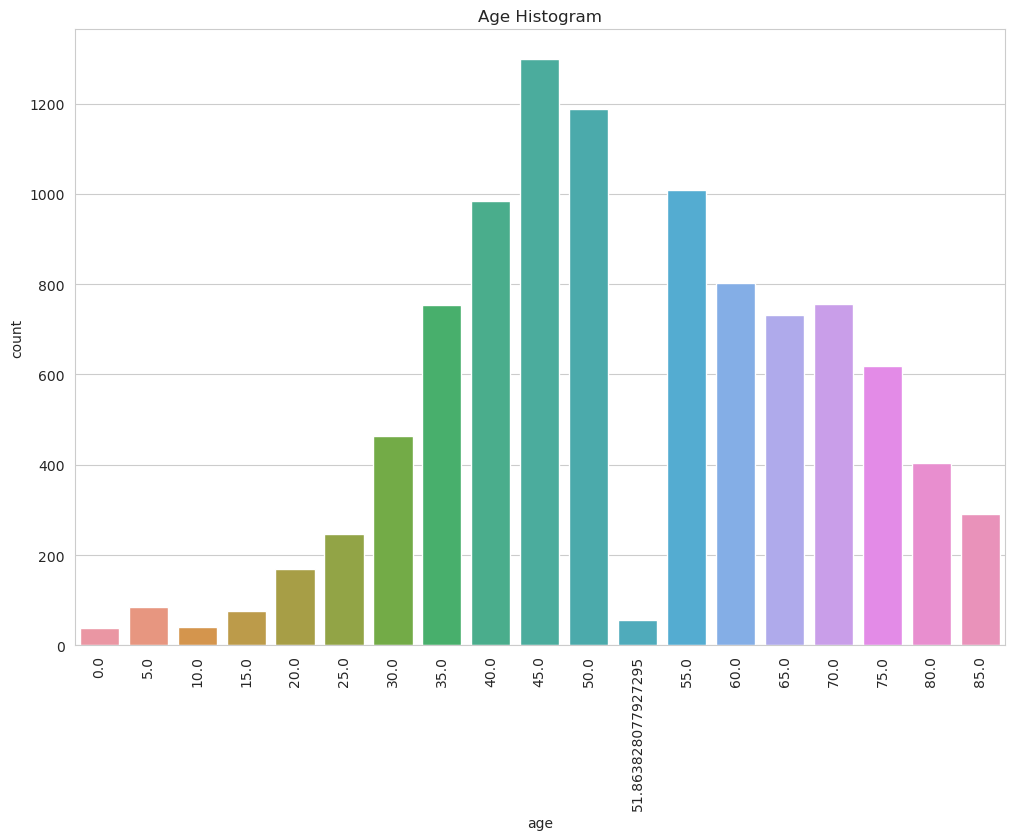

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'age', data = df)
plt.title('Age Histogram')
plt.xticks(rotation=90)
plt.show()

Gender wise age distribution

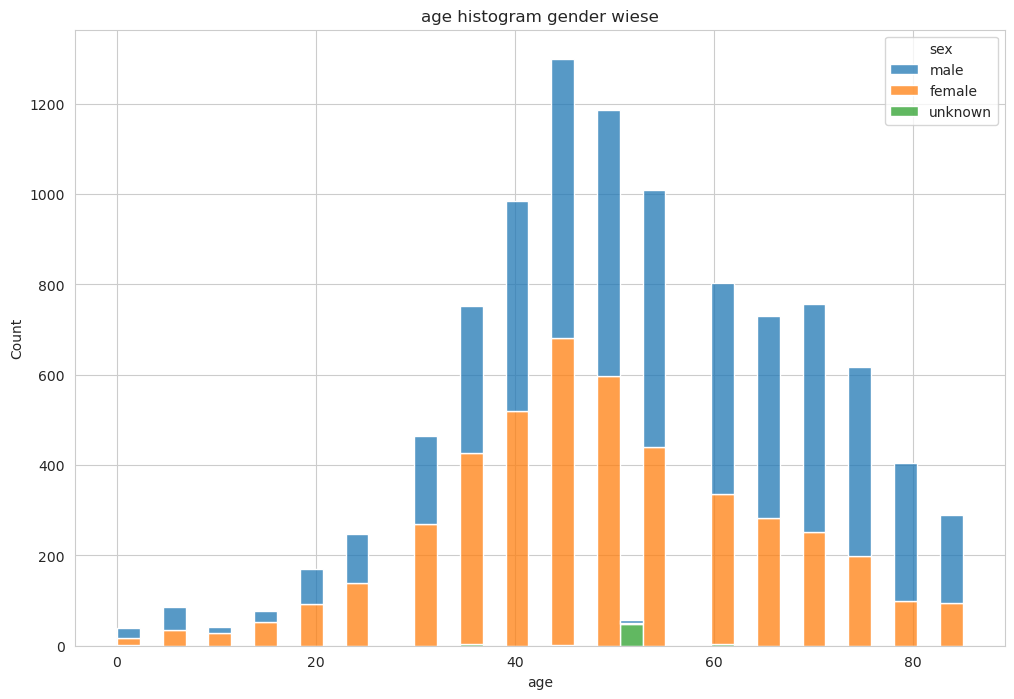

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x = 'age', hue = 'sex', multiple='stack')
plt.title('age histogram gender wiese')
plt.show()


Cell Type vs Age

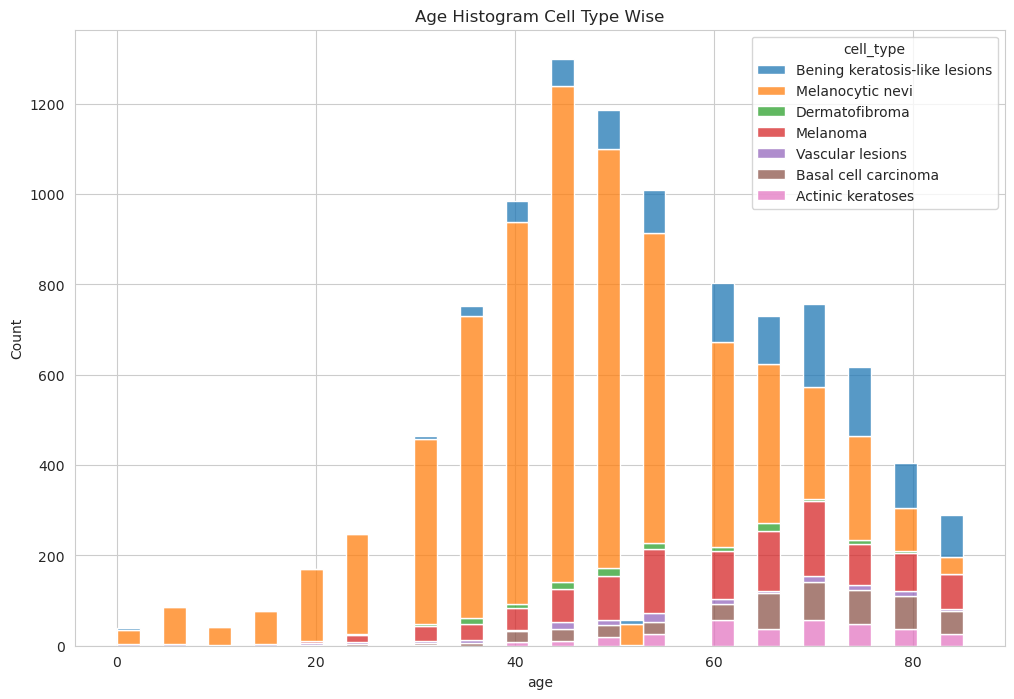

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

Localization area vs age

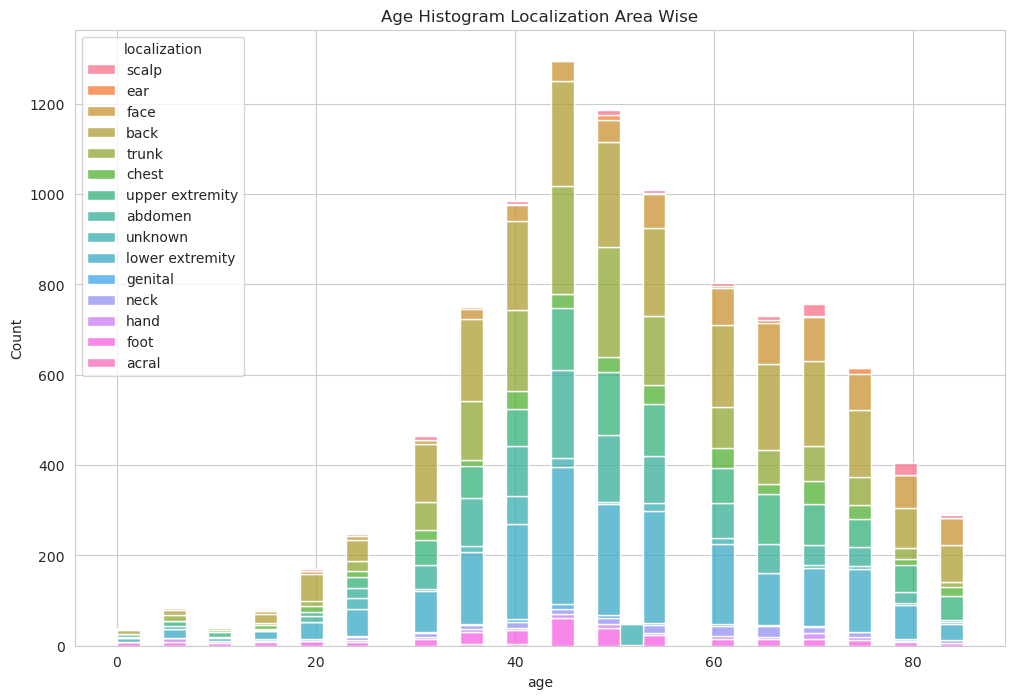

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

**Machine laarning part**

In [ ]:
import cv2

In [ ]:
# Function to read and resize images
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [ ]:
image_size = (64, 64)

In [ ]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

Pictorial representaiton of Images

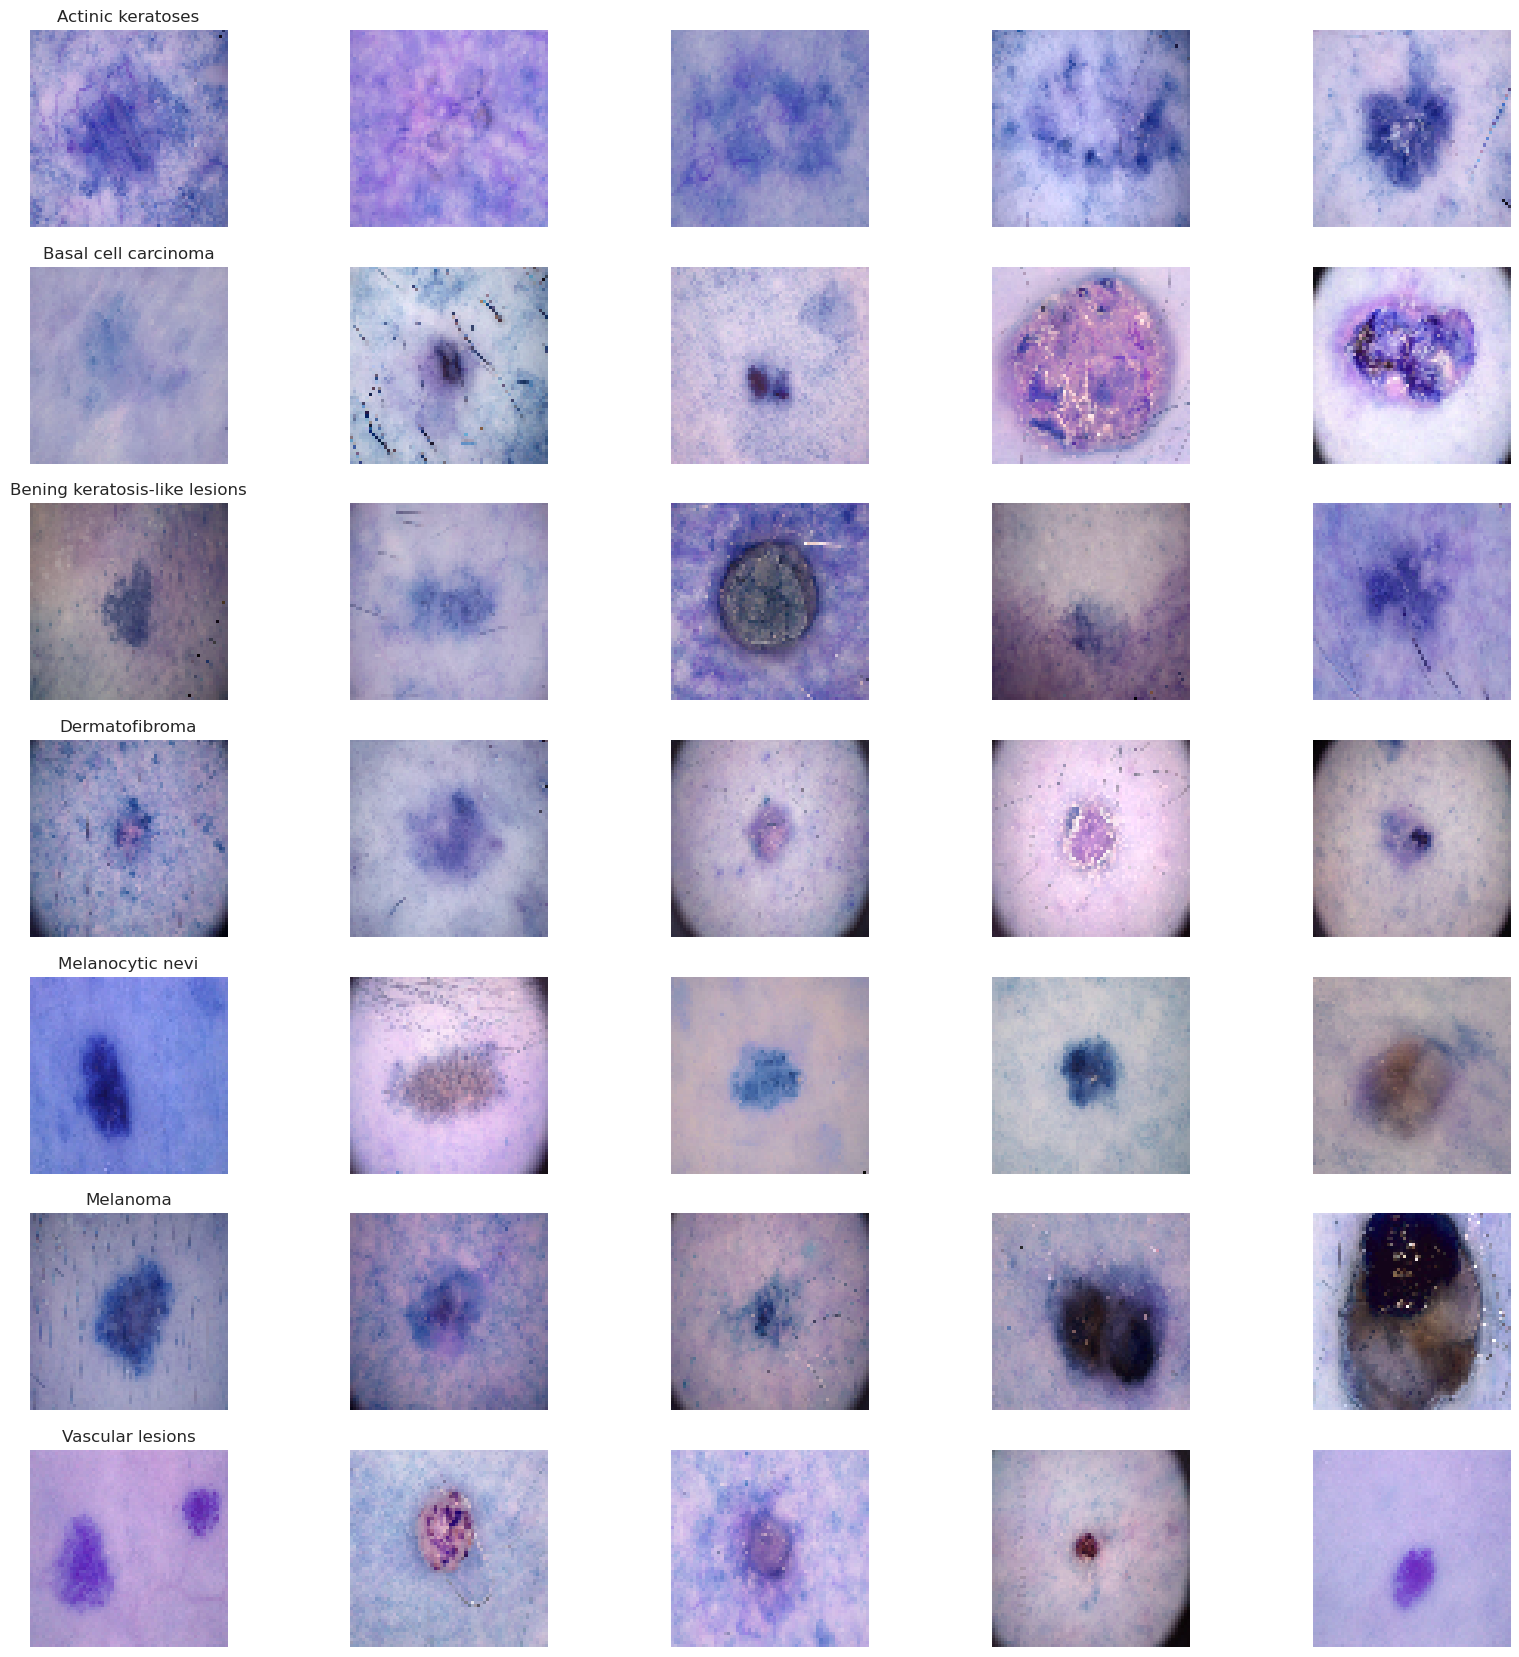

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    10015
Name: image, dtype: int64

**Data Modeling**

In [ ]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [ ]:
# Extract the image data and target labels for train and test sets
X_train = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [ ]:
def one_hot_encode(y):
  """One-hot encodes a vector of integers.

  Args:
    y: A vector of integers.

  Returns:
    A matrix of one-hot encoded vectors.
  """

  num_classes = len(set(y))
  y_one_hot = keras.utils.to_categorical(y, num_classes)
  return y_one_hot

y_train = one_hot_encode(y_train)

**Creating the CNN Model**

In [ ]:
import keras
model = Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
model.add(keras.layers.Flatten())

Compile the model


In [ ]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])


**Train the model**

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.1)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_28/3789252386.py", line 1, in <module>
      model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.1)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
      y, y_pred, sample_weight, regularization_losses=self.losses
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 2103, in sparse_categorical_crossentropy
      axis=axis,
    File "/opt/conda/lib/python3.7/site-packages/keras/backend.py", line 5634, in sparse_categorical_crossentropy
      labels=target, logits=output
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [128,7] and labels shape [896]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_66328]

In [ ]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the accuracy
accuracy = np.mean(y_pred_classes == y_test) * 100
print(f'Test accuracy: {accuracy:.2f}%')

In [ ]:
# Create a new DataFrame with 'lesion_id' and 'cell_type_dx' columns from the test data
result_df = pd.DataFrame({'lesion_id': test_df['lesion_id'], 'target': y_test})

# Save the DataFrame to a CSV file
result_df.to_csv('submission.csv', index=False)

In [ ]:
pd.read_csv('submission.csv')